# 타이타닉 생존자 가려내기

### step 1 탐색: 타이타닉 데이터 살펴보기
타이타닉 데이터셋의 구성은 다음과 같습니다.

+ pclass:Passenger Class, 승객 등급
+ survived: 생존 여부(생존은 1, 아닌 경우는 0)
+ name: 승객 이름
+ sex: 승객 성별
+ age: 승객 나이
+ sibsp: 동승한 형제 또는 배우자 수
+ parch: 동승한 부모 또는 자녀 수
+ ticket: 티켓 번호
+ fare: 승객 지불 요금
+ cabin: 선실 이름
+ embarked: 승선항(C=쉘 부르크, Q=퀸즈타운, S=사우스 햄튼)
+ body: 사망자 확인 번호
+ home.dest: 고향/목적지

분석에 사용할 데이터는 총 2개의 파일로 구성되어 있습니다.  
하나는 분류 모델의 학습을 위한 학습 데이터셋, 그리고 나머지 하나는 테스트를 위한 테스트 데이터셋입니다.  
그리고 각 데이터의 age,cabin,body,home,dest 피처에는 결측치가 존재합니다.  
다음의 코드로 이를 확인해 봅시다.

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv("./data/titanic_train.csv")
df_test = pd.read_csv("./data/titanic_test.csv")
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [4]:
print(df_train.info())
print("-----------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     393 non-

먼저 name,ticket,body, home.dest, cabin 피처를 제거합니다.  
이 피처들은 지금 당장 분석에 활용할 수 없거나 (name, cabin), 큰 의미를 가지고 있지 않은 피처(ticket, home.dest, body) 이기 때문입니다.

- 불필효한 피처 제거하기

In [5]:
# 데이터셋에서 name, ticket, body, cabin, home.dest 피처를 제거합니다.
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

다음으로 각 피처가 분류 분석에 미칠 영향에 대해 탐색해봅시다.  
이를 탐색하는 가장 좋은 방법은 데이터를 그룹(생존자 그룹 / 비생존자 그룹)으로 나누어 피처의 그룹 간 차이를 탐색하는 것입니다.  
생존 여부 (생존 = 1, 아닌 경우 = 0)인 survived를 그룹으로 하여 pclass 피처의 그룹별 분포를 출력한 결과는 아래와 같습니다.  
seaborn의 countplot이라는 함수를 사용하면 아래와 같은 그래프를 출력할 수 있습니다. 그룹 비율은 약 3:5 정도로 나타났고,  
그룹별 pclass의 분포는 상이하게 나타났습니다.  
이를 통해 pclass 피처는 생존자 분류에 유의미한 영향을 미친다는 가설을 세워 볼 수 있습니다.

+ 탐색적 데이터 분석하기

0    563
1    353
Name: survived, dtype: int64


<AxesSubplot:>

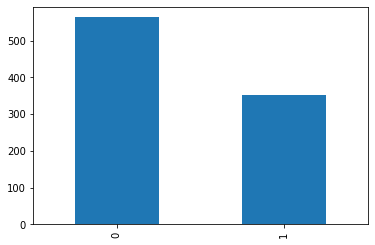

In [6]:
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

3    498
1    230
2    188
Name: pclass, dtype: int64


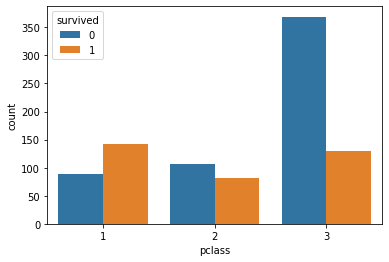

In [7]:
# survived 피처를 기준으로 그룹을 나누어, 그룹별 pclass 피처의 분포를 살펴봅니다.
print(df_train['pclass'].value_counts())
ax = sns.countplot(x='pclass', hue = 'survived',  data = df_train)

다음으로 age, sibsp와 같은 수치형 피처들에 대한 탐색을 진행합니다.  
다음의 코드는 이러한 피처들을 탐색할 수 있는 자동화 함수 valid_features()를 작성한 것입니다.  
함수가 실행하는 내용은 다음과 같습니다.  
  
    
+ 두 그룹 간의 분포를 비교하는 그래프를 출력합니다.
+ 두 그룹 각각의 표준편차를 출력합니다.
+ 두 그룹 간의 T-test 검정을 실시하여 출력합니다.
+ 두 그룹 각각에 Shapiro-wilk 검정을 실시하여 출력합니다.

##### shapiro - wilk 검정
Shapiro-wilk 검정이란 주어진 데이터가 얼마나 정규성을 따르는지. 즉 얼마나 정규분포에 가까운지를 측정하는 검정입니다.

+ 변수 탐색작업 자동화하기

In [8]:
from scipy import stats

# 두 집단의 피처를 비교해주며 탐색작업을 자동화하는 함수를 정의합니다.
def valid_features(df, col_name, distribution_check=True):
    
    # 두 집단 (survived=1, survived=0)의 분포 그래프를 출력합니다.
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)

    # 두 집단 (survived=1, survived=0)의 표준편차를 각각 출력합니다.
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_n_survived_static))
    
     # T-test로 두 집단의 평균 차이를 검정합니다.
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f." % tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정 : 분포의 정규성 정도를 검증합니다.
        print("The w-statistic and p-value in Survived %.3f and %.3f" % stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f" % stats.shapiro(titanic_n_survived[col_name]))

아래의 실행 결과는 valid_features()를 실행한 것입니다. 이를 통해 살펴본 피처는 age, sibsp 두 피처입니다.

+ 자동화 함수 실행하기

data std is 14.22
data std is 13.71
The t-statistic and p-value assuming equal variances is -0.546 and 0.585.
The t-statistic and p-value not assuming equal variances is -0.543 and 0.587
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Non-Survived 0.968 and 0.000
data std is 0.64
data std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034.
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


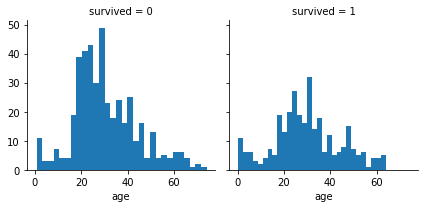

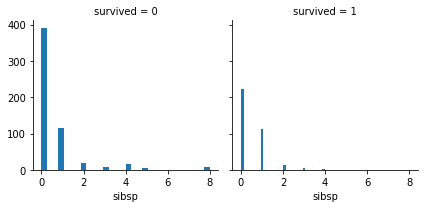

In [11]:
# 앞서 정의한 valid_features 함수를 실행합니다. age 피처와 sibsp 피처를 탐색합니다.
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check=True)
valid_features(df_train, 'sibsp', distribution_check=False)

분석 결과, age 피처는 두 그룹 간의 평균 차이가 없기 때문에 생존자 분류에 미치는 영향력이 낮을것이라고 가정해볼 수 있습니다.  
반면 sibsp 피처에서는 두 그룹 간의 평균 차이가 어느 정도 존재 한다는것을 알 수 있습니다.

다음의 표는 지금까지 탐색한 피처의 내용을 정리한 것입니다.

탐색 대상 피처 | 두 그룹 간의 분포 혹은 평균의 차이가 있는가?
--- | ---
pclass | O
age | x
sibsp,parch | △
fare | O
sex | O
embarked | △

# step 2 분류: 생존자 분류 모델 만들기